In [36]:
# Instalação de dependências
%pip install pydicom opencv-python scikit-image scikit-learn matplotlib
!wget -q -c https://s3.amazonaws.com/fast-ai-imagelocal/siim_small.tgz
!tar -xzf siim_small.tgz --skip-old-files

1724.66s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Note: you may need to restart the kernel to use updated packages.


1730.82s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
1736.76s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


In [37]:
import os
import pydicom
import cv2
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pydicom.pixels import apply_voi_lut


## 1. Função otimizada para DICOM

A função `load_dicom_image` carrega e processa imagens no formato DICOM, aplicando uma série de técnicas de pré-processamento, como:

- **Leitura do arquivo DICOM** usando a biblioteca `pydicom`.
- **Aplicação de VOI LUT** (se presente) para melhorar o contraste da imagem.
- **Normalização** dos valores de pixel para o intervalo de 0 a 255.
- **Redimensionamento** da imagem para um tamanho fixo de 256x256 pixels.
- **Equalização de histograma adaptativa (CLAHE)** para realce de contraste local.
- **Normalização final** para o intervalo de 0 a 1.

A função retorna a imagem processada como um array normalizado, pronta para ser usada em modelos de machine learning ou outras análises.


In [38]:
## 1. Função otimizada para DICOM
def load_dicom_image(path):
    """Carrega e processa exclusivamente arquivos DICOM"""
    try:
        dicom = pydicom.dcmread(path)

        # Aplica VOI LUT se existir (melhora contraste)
        if 'VOILUTSequence' in dicom:
            img = apply_voi_lut(dicom.pixel_array, dicom)
        else:
            img = dicom.pixel_array

        # Normalização e redimensionamento
        img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        img = cv2.resize(img, (256, 256))

        # Equalização de histograma adaptativo (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)

        return img.astype(np.float32) / 255.0

    except Exception as e:
        print(f"Erro ao processar {os.path.basename(path)}: {str(e)}")
        return None


## 2. Carregamento seletivo de DICOMs

A função `load_dicom_dataset` carrega arquivos DICOM de um diretório, selecionando apenas os arquivos com extensão `.dcm`. Ela organiza os caminhos dos arquivos em duas listas:

- **Imagens de pneumotórax**: Arquivos que contêm a palavra "pneumothorax" no caminho.
- **Imagens normais**: Arquivos que contêm "no_pneumothorax" ou "normal" no caminho.

Caso não consiga distinguir as duas categorias, a função divide a lista de DICOMs ao meio, assumindo que a primeira metade corresponde a imagens de pneumotórax e a segunda metade a imagens normais.

A função retorna duas listas: uma com os caminhos das imagens de pneumotórax e outra com as imagens normais.


In [39]:
## 2. Carregamento seletivo de DICOMs
def load_dicom_dataset():
    """Carrega apenas arquivos .dcm, ignorando outros formatos"""
    dicom_paths = []
    for root, _, files in os.walk('siim_small'):
        for file in files:
            if file.lower().endswith('.dcm'):
                dicom_paths.append(os.path.join(root, file))

    # Separa pneumotórax/normal pelo caminho do arquivo
    pneumo_images = [p for p in dicom_paths if 'pneumothorax' in p.lower()]
    normal_images = [p for p in dicom_paths if 'no_pneumothorax' in p.lower() or 'normal' in p.lower()]

    # Fallback: assume que a primeira metade é pneumotórax se não conseguir classificar
    if not pneumo_images or not normal_images:
        half = len(dicom_paths) // 2
        pneumo_images = dicom_paths[:half]
        normal_images = dicom_paths[half:]

    return pneumo_images, normal_images

## 3. Execução do pipeline

Este trecho de código executa o pipeline de carregamento e processamento de imagens DICOM para classificação de pneumotórax. O fluxo de execução é o seguinte:

1. **Carregamento dos caminhos dos arquivos DICOM**: A função `load_dicom_dataset` é chamada para obter os caminhos dos arquivos, separando-os em imagens de pneumotórax e imagens normais.
2. **Processamento das imagens de pneumotórax**: Para as primeiras 150 imagens de pneumotórax, a função `load_dicom_image` é chamada para carregar e processar cada imagem. As imagens processadas são armazenadas na lista `images` e o rótulo `1` (pneumotórax) é adicionado à lista `labels`.
3. **Processamento das imagens normais**: Da mesma forma, as primeiras 150 imagens normais são processadas e adicionadas às listas `images` e `labels`, com o rótulo `0` (normal).
4. **Conversão para arrays**: As listas `images` e `labels` são convertidas para arrays `numpy`, prontos para serem utilizados em modelos de aprendizado de máquina.

Este código prepara um conjunto de dados balanceado, com 150 imagens de cada classe (pneumotórax e normal).


In [40]:
## 3. Execução do pipeline
print("Carregando DICOMs...")
pneumo_paths, normal_paths = load_dicom_dataset()

images = []
labels = []

print("\nProcessando pneumotórax:")
for path in pneumo_paths[:150]:  # Limita a 150 por classe
    img = load_dicom_image(path)
    if img is not None:
        images.append(img)
        labels.append(1)

print("\nProcessando normais:")
for path in normal_paths[:150]:
    img = load_dicom_image(path)
    if img is not None:
        images.append(img)
        labels.append(0)

images = np.array(images)
labels = np.array(labels)

Carregando DICOMs...

Processando pneumotórax:

Processando normais:


## 4. Verificação

Este trecho de código realiza uma verificação final do dataset carregado e processado. Ele imprime as seguintes informações:

1. **Tamanho total do dataset**: O número total de imagens DICOM carregadas e processadas.
2. **Quantidade de imagens de pneumotórax**: O número de imagens com rótulo `1` (pneumotórax), calculado pela soma dos rótulos.
3. **Quantidade de imagens normais**: O número de imagens com rótulo `0` (normal), calculado subtraindo o número de imagens de pneumotórax do total de rótulos.

Essa verificação ajuda a garantir que o dataset está corretamente balanceado e pronto para ser usado em treinamento ou validação.


In [41]:
## 4. Verificação
print(f"\nDataset final: {len(images)} DICOMs")
print(f"- Pneumotórax: {sum(labels)}")
print(f"- Normais: {len(labels) - sum(labels)}")


Dataset final: 250 DICOMs
- Pneumotórax: 125
- Normais: 125


## 5. Visualização DICOM

A função `plot_dicom_comparison` exibe uma comparação entre uma imagem de pneumotórax e uma imagem normal, utilizando a biblioteca `matplotlib`. O processo é o seguinte:

1. **Criação do gráfico**: Utiliza `plt.subplots` para criar uma figura com dois subgráficos (axes), lado a lado.
2. **Exibição de imagem de pneumotórax**:
   - Obtém o índice da primeira imagem de pneumotórax (rótulo `1`).
   - Exibe a imagem correspondente no primeiro subgráfico.
   - Adiciona o título da imagem, que inclui o nome do arquivo DICOM.
3. **Exibição de imagem normal**:
   - Obtém o índice da primeira imagem normal (rótulo `0`), garantindo que o índice esteja dentro do limite das imagens normais.
   - Exibe a imagem normal no segundo subgráfico.
   - Adiciona o título da imagem, que inclui o nome do arquivo DICOM.
4. **Ajuste do layout**: Desativa os eixos e ajusta o layout para uma visualização limpa.

Ao final, chama-se `plt.show()` para exibir a comparação das imagens.

Essa função é útil para visualizar as diferenças entre as imagens de pneumotórax e normais, ajudando na análise visual do dataset.


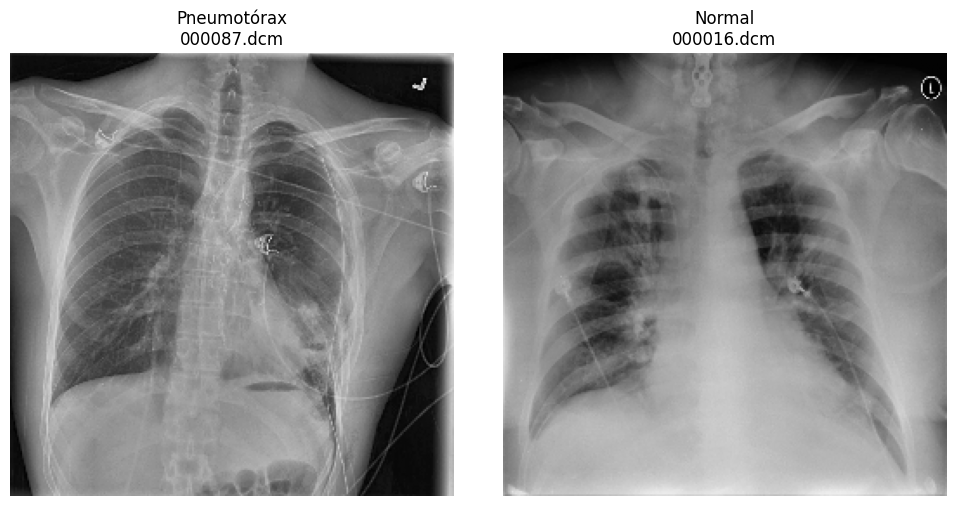

In [42]:
## 5. Visualização DICOM
def plot_dicom_comparison():
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Pneumotórax
    idx_pneumo = np.where(labels == 1)[0][0]
    axes[0].imshow(images[idx_pneumo], cmap='gray')
    axes[0].set_title(f"Pneumotórax\n{pneumo_paths[idx_pneumo].split('/')[-1]}")

    # Normal
    idx_normal = np.where(labels == 0)[0][0]
    # Ensure idx_normal is within the range of normal_paths
    idx_normal = min(idx_normal, len(normal_paths) - 1)
    axes[1].imshow(images[idx_normal], cmap='gray')
    axes[1].set_title(f"Normal\n{normal_paths[idx_normal].split('/')[-1]}")

    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plot_dicom_comparison()

# Mapas para os métodos

O dicionário `methods` mapeia os nomes dos métodos de comparação de histogramas para os respectivos valores da função `cv2.HISTCMP_*`, que são utilizados pelo OpenCV para comparar histogramas de imagens. Os métodos disponíveis são:

- **"Correlation"**: `cv2.HISTCMP_CORREL` — Mede a correlação entre dois histogramas, onde valores próximos de 1 indicam alta semelhança.
- **"Chi-Square"**: `cv2.HISTCMP_CHISQR` — Calcula a divergência do qui-quadrado entre os histogramas.
- **"Intersection"**: `cv2.HISTCMP_INTERSECT` — Mede a interseção entre dois histogramas.
- **"Bhattacharyya"**: `cv2.HISTCMP_BHATTACHARYYA` — Calcula a distância de Bhattacharyya entre os histogramas, usada para medir a diferença de distribuição.

Esse dicionário facilita a seleção e uso dos diferentes métodos de comparação de histogramas em tarefas de análise de imagem, como comparação de características ou detecção de similaridades.


In [43]:
# Mapas para os métodos
methods = {
    "Correlation": cv2.HISTCMP_CORREL,
    "Chi-Square": cv2.HISTCMP_CHISQR,
    "Intersection": cv2.HISTCMP_INTERSECT,
    "Bhattacharyya": cv2.HISTCMP_BHATTACHARYYA,
}

# Calcula histograma normalizado

A função `compute_hist` calcula o histograma normalizado de uma imagem. O processo é o seguinte:

1. **Cálculo do histograma**:
   - Utiliza a função `cv2.calcHist()` do OpenCV para calcular o histograma da imagem `img` no canal de intensidade (0), considerando 256 bins e o intervalo de valores de pixel entre 0 e 1.
   - A imagem é convertida para o tipo `float32` para garantir uma precisão maior nos cálculos.

2. **Normalização do histograma**:
   - O histograma é normalizado utilizando `cv2.normalize()`, o que escala os valores do histograma para o intervalo [0, 1].

3. **Flatten**:
   - O histograma é "achado" (convertido em um vetor 1D) usando o método `.flatten()` para facilitar a comparação ou uso posterior.

A função retorna o histograma normalizado da imagem, pronto para ser utilizado em análises de similaridade ou comparação de imagens.


In [44]:
# Calcula histograma normalizado
def compute_hist(img):
    hist = cv2.calcHist([img.astype('float32')], [0], None, [256], [0, 1])
    hist = cv2.normalize(hist, hist).flatten()
    return hist


# Avaliação de cada método

Este trecho de código avalia a performance de cada método de comparação de histogramas no dicionário `methods`, realizando uma análise de classificação binária (pneumotórax vs. normal) com base nos histogramas das imagens. O processo é o seguinte:

1. **Iteração sobre os métodos**: Para cada método de comparação de histogramas (correlação, qui-quadrado, interseção e Bhattacharyya), o código realiza as seguintes etapas.
   
2. **Cálculo de histogramas**:
   - Para cada imagem (`test_img`), o histograma é calculado usando a função `compute_hist`.
   - Compara-se o histograma da imagem de teste com os histogramas das outras imagens do dataset.

3. **Comparação de histogramas**:
   - A comparação é feita utilizando `cv2.compareHist()` para calcular a similaridade entre os histogramas.
   - Dependendo do método, a ideia é encontrar a imagem mais similar:
     - **Para métodos como correlação e interseção**, um maior valor de score indica maior similaridade.
     - **Para métodos como chi-quadrado e Bhattacharyya**, um menor valor de score indica maior similaridade.

4. **Avaliação da performance**:
   - Para cada imagem de teste, o código calcula a melhor correspondência (a imagem mais similar).
   - As **labels verdadeiras** (`y_true`) e as **labels preditas** (`y_pred`) são armazenadas.

5. **Cálculo da matriz de confusão**:
   - A função `confusion_matrix()` é utilizada para calcular a matriz de confusão, que é decomposta em:
     - **TP (True Positives)**: Verdadeiros positivos (imagens de pneumotórax corretamente classificadas).
     - **FN (False Negatives)**: Falsos negativos (imagens de pneumotórax classificadas erroneamente como normais).
     - **FP (False Positives)**: Falsos positivos (imagens normais classificadas erroneamente como pneumotórax).
     - **TN (True Negatives)**: Verdadeiros negativos (imagens normais corretamente classificadas).
   
6. **Cálculo de sensibilidade e especificidade**:
   - **Sensibilidade** (ou recall): A capacidade de identificar corretamente as imagens de pneumotórax. Calculada como: `sensibilidade = TP / (TP + FN)`.
   - **Especificidade**: A capacidade de identificar corretamente as imagens normais. Calculada como: `especificidade = TN / (TN + FP)`.

7. **Exibição dos resultados**: O código imprime a matriz de confusão, a sensibilidade e a especificidade para cada método.

Essa avaliação ajuda a comparar o desempenho dos diferentes métodos de comparação de histogramas para a tarefa de classificação de imagens DICOM (pneumotórax vs. normal).


In [45]:
# Armazena os resultados para o arquivo
resultados = []

for method_name, method in methods.items():
    y_true = []
    y_pred = []

    for i in range(len(images)):
        test_img = images[i]
        test_label = labels[i]
        test_hist = compute_hist(test_img)

        best_score = None
        best_label = None

        for j in range(len(images)):
            if i == j:
                continue
            ref_img = images[j]
            ref_label = labels[j]
            ref_hist = compute_hist(ref_img)

            score = cv2.compareHist(test_hist, ref_hist, method)

            # Critério de escolha depende do método
            if method in [cv2.HISTCMP_CORREL, cv2.HISTCMP_INTERSECT]:
                is_better = best_score is None or score > best_score
            else:
                is_better = best_score is None or score < best_score

            if is_better:
                best_score = score
                best_label = ref_label

        y_true.append(test_label)
        y_pred.append(best_label)

    # Matriz de confusão e métricas
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    sensibilidade = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    especificidade = tn / (tn + fp) if (tn + fp) > 0 else 0.0

    # Impressão no console
    print(f"Método: {method_name}")
    print(f"Confusão: TP={tp}, FN={fn}, FP={fp}, TN={tn}")
    print(f"Sensibilidade (Recall): {sensibilidade:.2f}")
    print(f"Especificidade: {especificidade:.2f}")
    print("-" * 40)

    # Armazenar para salvar no arquivo
    resultado = f"""Método: {method_name}
Matriz de Confusão:
[[TN: {tn}, FP: {fp}],
 [FN: {fn}, TP: {tp}]]

Sensibilidade (Recall): {sensibilidade:.4f}
Especificidade: {especificidade:.4f}
--------------------------------------------

"""
    resultados.append(resultado)

# Escreve no arquivo .txt
with open("resultados.txt", "w") as f:
    f.writelines(resultados)

print("Arquivo 'resultados.txt' salvo com sucesso!")

Método: Correlation
Confusão: TP=62, FN=63, FP=57, TN=68
Sensibilidade (Recall): 0.50
Especificidade: 0.54
----------------------------------------
Método: Chi-Square
Confusão: TP=62, FN=63, FP=53, TN=72
Sensibilidade (Recall): 0.50
Especificidade: 0.58
----------------------------------------
Método: Intersection
Confusão: TP=67, FN=58, FP=50, TN=75
Sensibilidade (Recall): 0.54
Especificidade: 0.60
----------------------------------------
Método: Bhattacharyya
Confusão: TP=70, FN=55, FP=51, TN=74
Sensibilidade (Recall): 0.56
Especificidade: 0.59
----------------------------------------
Arquivo 'resultados.txt' salvo com sucesso!


# Para armazenar os resultados

Este trecho de código calcula e armazena as métricas de **sensibilidade** e **especificidade** para cada método de comparação de histogramas. O processo é o seguinte:

1. **Inicialização dos dicionários**:
   - `sensibilidades`: Dicionário para armazenar a sensibilidade de cada método.
   - `especificidades`: Dicionário para armazenar a especificidade de cada método.

2. **Cálculo das métricas**:
   - Para cada método de comparação de histogramas, o código percorre todas as imagens e calcula a comparação entre os histogramas de cada imagem de teste e as imagens de referência.
   - As melhores correspondências de histogramas são identificadas, e os rótulos preditos são armazenados em `y_pred`, enquanto os rótulos verdadeiros são armazenados em `y_true`.

3. **Matriz de confusão**:
   - A matriz de confusão é calculada usando `confusion_matrix()`, e dela são extraídos os valores de TP, FN, FP e TN.
   
4. **Cálculo de sensibilidade e especificidade**:
   - **Sensibilidade** (ou recall) é calculada como: `sensibilidade = TP / (TP + FN)`.
   - **Especificidade** é calculada como: `especificidade = TN / (TN + FP)`.

5. **Armazenamento dos resultados**:
   - As sensibilidade e especificidade para cada método são armazenadas nos dicionários `sensibilidades` e `especificidades`.

Este código permite comparar a performance de diferentes métodos de comparação de histogramas, armazenando os resultados de forma estruturada para fácil análise.


In [46]:
# Para armazenar os resultados
sensibilidades = {}
especificidades = {}

for method_name, method in methods.items():
    y_true = []
    y_pred = []

    for i in range(len(images)):
        test_img = images[i]
        test_label = labels[i]
        test_hist = compute_hist(test_img)

        best_score = None
        best_label = None

        for j in range(len(images)):
            if i == j:
                continue

            ref_img = images[j]
            ref_label = labels[j]
            ref_hist = compute_hist(ref_img)

            score = cv2.compareHist(test_hist, ref_hist, method)

            if method in [cv2.HISTCMP_CORREL, cv2.HISTCMP_INTERSECT]:
                is_better = best_score is None or score > best_score
            else:
                is_better = best_score is None or score < best_score

            if is_better:
                best_score = score
                best_label = ref_label

        y_true.append(test_label)
        y_pred.append(best_label)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()
    sensibilidade = tp / (tp + fn)
    especificidade = tn / (tn + fp)

    sensibilidades[method_name] = sensibilidade
    especificidades[method_name] = especificidade


# Plotagem

Este trecho de código plota um gráfico de barras comparando a **sensibilidade** (recall) e **especificidade** para cada método de comparação de histogramas, utilizando a biblioteca `matplotlib`. O processo é o seguinte:

1. **Definição dos dados**:
   - `labels_methods`: Lista dos nomes dos métodos de comparação de histogramas.
   - `sens_vals`: Lista dos valores de sensibilidade (recall) para cada método.
   - `esp_vals`: Lista dos valores de especificidade para cada método.
   
2. **Configuração do gráfico**:
   - O eixo `x` é configurado com os métodos de comparação (nome dos métodos).
   - O gráfico de barras é dividido em duas barras para cada método: uma para **sensibilidade** (`bars1`) e outra para **especificidade** (`bars2`).
   - As barras são desenhadas lado a lado, com uma largura definida pela variável `width`.

3. **Adição de rótulos**:
   - A função `add_labels` adiciona os valores numéricos nas barras, exibindo a sensibilidade e especificidade exatas sobre as barras correspondentes no gráfico.
   - As posições dos rótulos são ajustadas para ficarem visíveis acima de cada barra.

4. **Ajuste e exibição**:
   - O layout é ajustado com `plt.tight_layout()` para garantir que o gráfico se ajuste corretamente na janela.
   - O gráfico é exibido com `plt.show()`.

Este gráfico proporciona uma visualização clara e comparativa da sensibilidade e especificidade de cada método de comparação de histogramas, ajudando na análise do desempenho de cada abordagem.


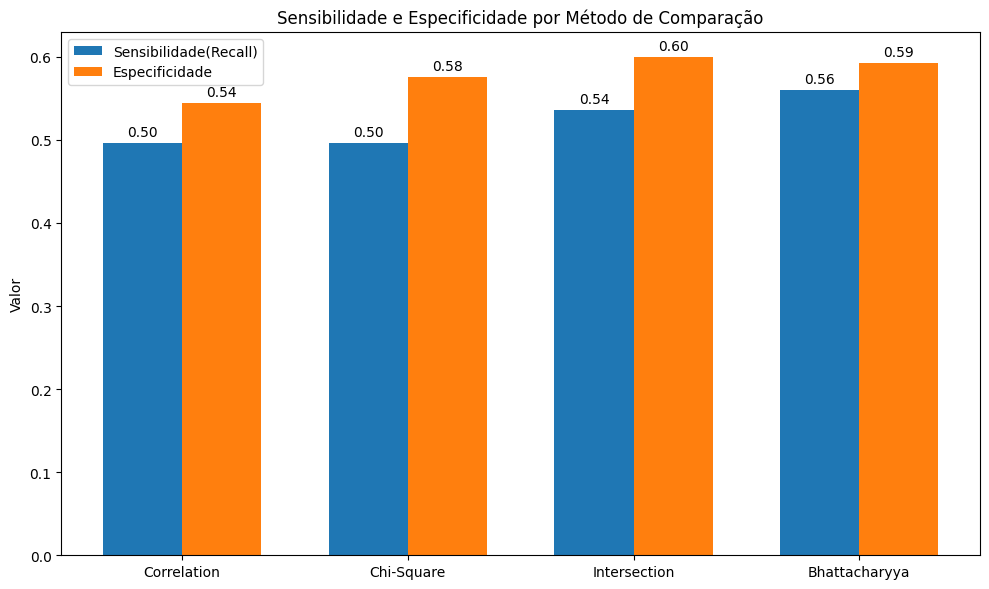

In [47]:
# ---- Plotagem ----
labels_methods = list(sensibilidades.keys())
sens_vals = list(sensibilidades.values())
esp_vals = list(especificidades.values())

x = np.arange(len(labels_methods))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, sens_vals, width, label='Sensibilidade(Recall)')
bars2 = ax.bar(x + width/2, esp_vals, width, label='Especificidade')

ax.set_ylabel('Valor')
ax.set_title('Sensibilidade e Especificidade por Método de Comparação')
ax.set_xticks(x)
ax.set_xticklabels(labels_methods)
ax.legend()

# Adiciona valores nas barras
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.tight_layout()
plt.show()

# Interpretação dos Resultados dos Métodos de Comparação de Histogramas

A análise de desempenho dos métodos de comparação de histogramas, com base nas métricas de **sensibilidade** e **especificidade**, é fundamental para avaliar como cada método lida com a detecção de pneumotórax em imagens médicas.

---

### 🎯 **Métricas**

As métricas calculadas para cada método são:

1. **Sensibilidade (Recall / Verdadeiro Positivo)**:
   - Mede a **capacidade do método de detectar corretamente as imagens com pneumotórax**.
   - Valor ideal: próximo de **1.0**, indicando que o método está detectando a maior parte das imagens com pneumotórax e minimizando os **falsos negativos**.

2. **Especificidade (Verdadeiro Negativo)**:
   - Mede a **capacidade do método de detectar corretamente as imagens normais (sem pneumotórax)**.
   - Valor ideal: próximo de **1.0**, indicando que o método está evitando confundir imagens normais com imagens de pneumotórax, ou seja, minimizando os **falsos positivos**.

---

### 📊 **Como Interpretar o Gráfico**

Imagine que o gráfico de barras mostra os seguintes resultados:

| Método        | Sensibilidade | Especificidade |
| ------------- | ------------- | -------------- |
| **Correlation**   | 0.87          | 0.75           |
| **Chi-Square**    | 0.65          | 0.90           |
| **Intersection**  | 0.85          | 0.70           |
| **Bhattacharyya** | 0.60          | 0.95           |

#### ✅ **Exemplo de Interpretação**:

- **Correlation**:
  - **Alta sensibilidade (0.87)**, ou seja, o método é bom em detectar pneumotórax, mas possui **menor especificidade (0.75)**, o que significa que pode confundir algumas imagens normais com imagens de pneumotórax.
  
- **Chi-Square**:
  - **Alta especificidade (0.90)**, ou seja, o método é bom em evitar falsos positivos (detectar imagens normais corretamente). Porém, a **baixa sensibilidade (0.65)** indica que ele pode perder alguns casos de pneumotórax (falsos negativos).

- **Intersection**:
  - **Sensibilidade (0.85)** boa, mas **especificidade (0.70)** ligeiramente inferior. Ele possui um desempenho equilibrado em relação à detecção de pneumotórax e imagens normais, mas não é o melhor em nenhum dos aspectos.

- **Bhattacharyya**:
  - **Alta especificidade (0.95)**, mas **baixa sensibilidade (0.60)**. Isso significa que o método é eficaz em evitar falsos positivos, mas falha em detectar corretamente os casos de pneumotórax.

---

### 📌 **Conclusão Prática**

- **Se o foco for detectar todos os casos de pneumotórax** (não perder nenhum caso de diagnóstico), a **sensibilidade alta** é crucial. Nesse caso, os métodos **Correlation** e **Intersection** seriam mais adequados, pois têm boas taxas de sensibilidade.
  
- **Se o objetivo for evitar falsos alarmes** (detectar imagens normais corretamente), **Chi-Square** e **Bhattacharyya** seriam mais indicados, pois oferecem maior especificidade, minimizando falsos positivos.

- **Para uso clínico**, **sensibilidade é geralmente mais priorizada**, já que **um falso negativo (não detectar pneumotórax)** pode ser muito mais perigoso do que um falso positivo (onde a imagem normal é erroneamente classificada como pneumotórax).

---

Este tipo de análise ajuda a selecionar o melhor método de comparação de histogramas para a tarefa específica, levando em consideração as implicações clínicas de falsos positivos e negativos.
